# 1. Setup

## Load libraries

In [3]:
import cv2
import gc
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.python.framework import ops
from time import time

ASSETS = './assets/'

In [57]:
def reset_session():
    ops.reset_default_graph()
    gc.collect()
    K.clear_session()
    
reset_session()

# 2. Explore data

## Number of images per a set

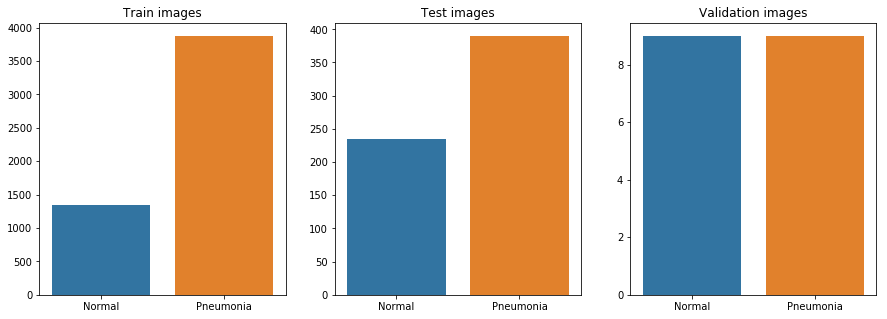

In [26]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

def display_image_counts(images_set, index, label):
    normal_count = len(os.listdir(f'{ASSETS}{images_set}/NORMAL'))
    pneumonia_count = len(os.listdir(f'{ASSETS}{images_set}/PNEUMONIA'))
    plt.subplot(1, 3, index)
    plt.title(label)
    sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_count, pneumonia_count])

display_image_counts('train', 1, 'Train images')
display_image_counts('test', 2, 'Test images')
display_image_counts('val', 3, 'Validation images')

plt.show()

## Display sample images from each set

train - NORMAL


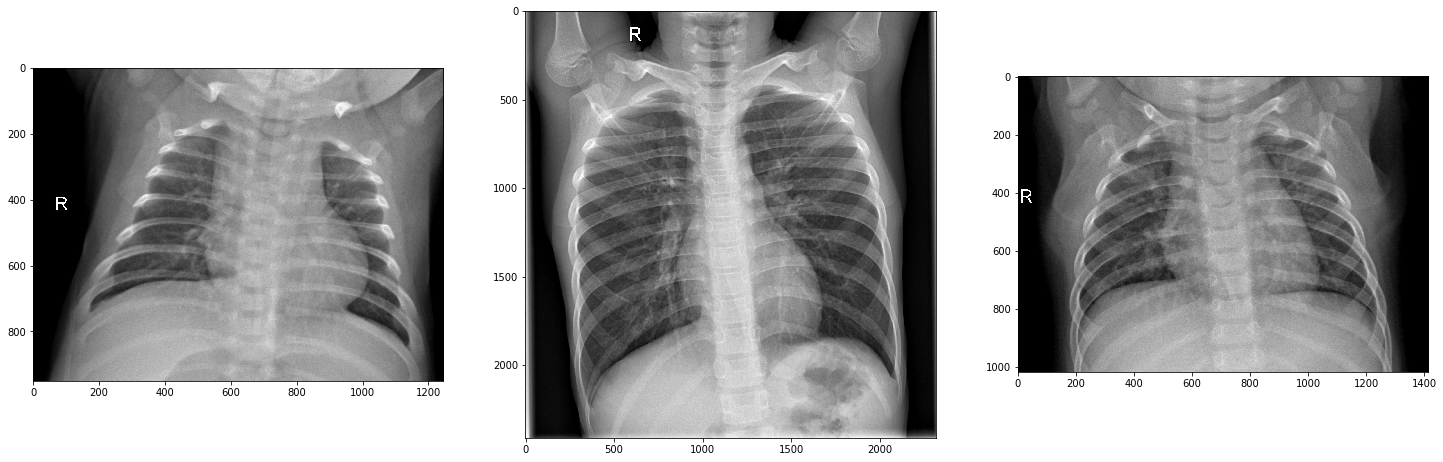

train - PNEUMONIA


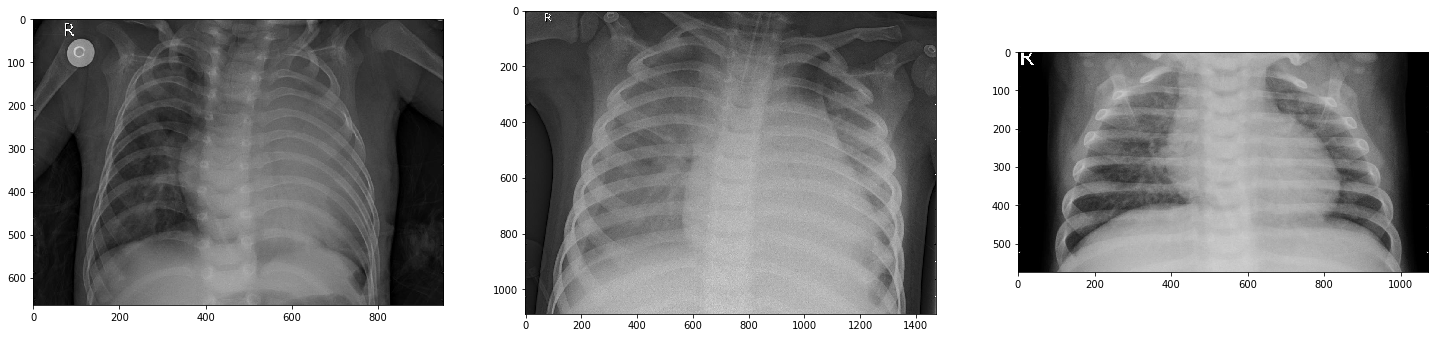

test - NORMAL


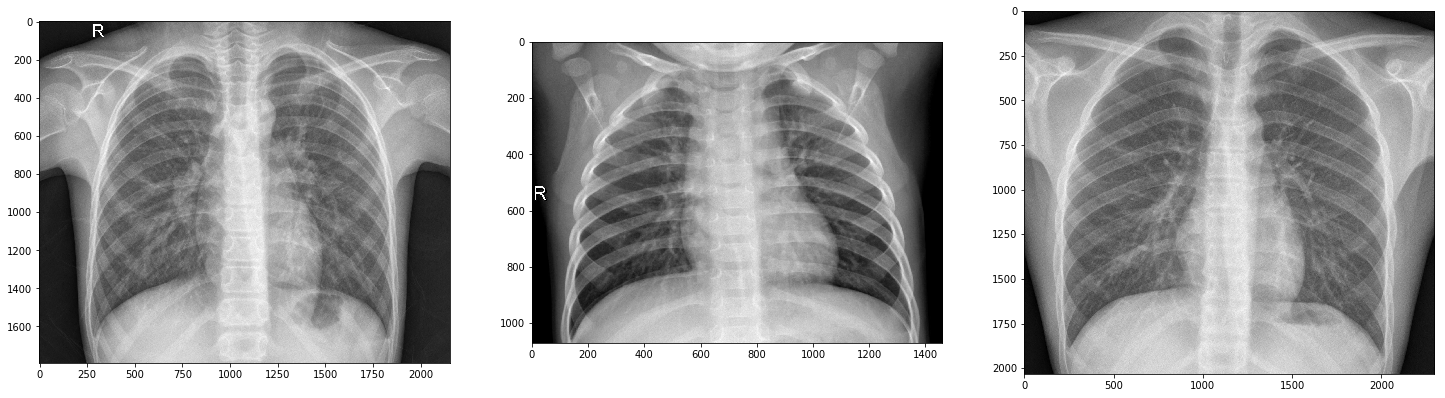

test - PNEUMONIA


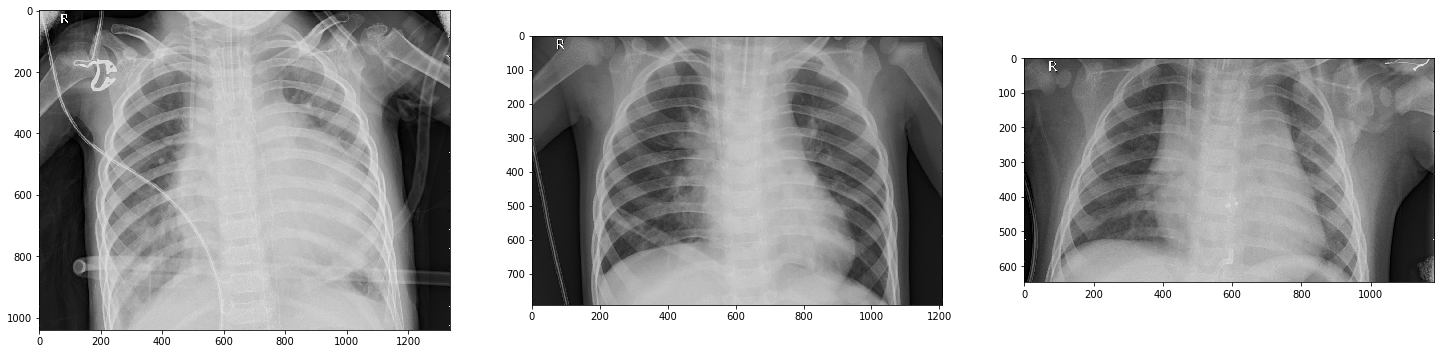

val - NORMAL


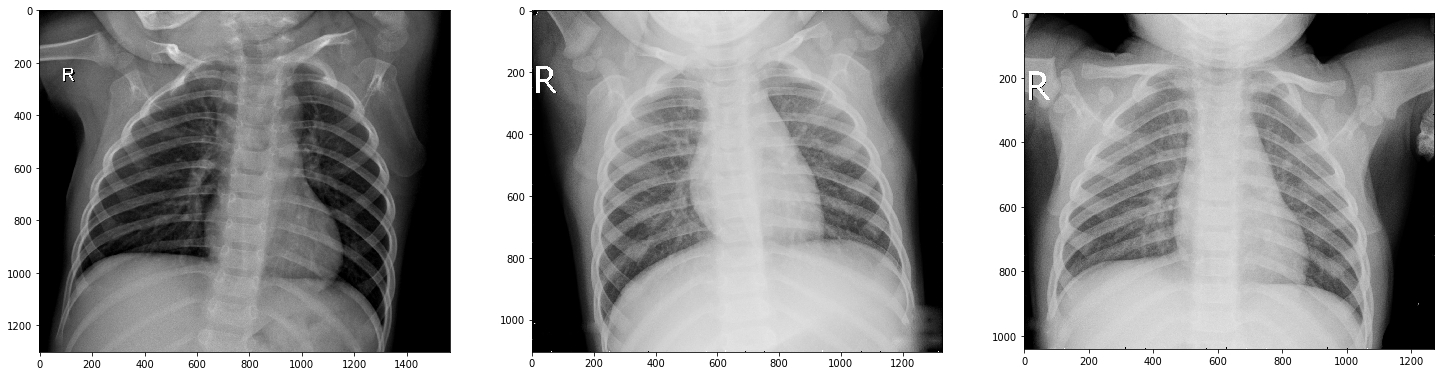

val - PNEUMONIA


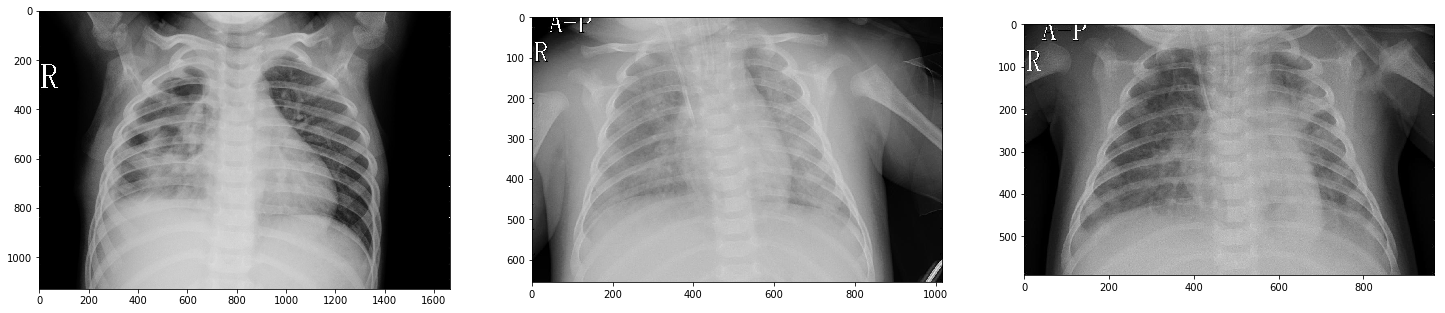

In [27]:
def list_images(images_set, images_class, count = 3):
    print(f'{images_set} - {images_class}')
    plt.subplots(nrows=1, ncols=5, figsize=(25, 25))

    folder_path = f'{ASSETS}{images_set}/{images_class}'
    image_paths = glob.glob(f'{folder_path}/*.jpeg')
    selected_image_paths = np.random.choice(image_paths, count)

    for idx, image_path in enumerate(selected_image_paths):
        image = cv2.imread(image_path)
        plt.subplot(1, count, idx + 1)
        plt.imshow(image)
    plt.show()

list_images('train', 'NORMAL')
list_images('train', 'PNEUMONIA')

list_images('test', 'NORMAL')
list_images('test', 'PNEUMONIA')

list_images('val', 'NORMAL')
list_images('val', 'PNEUMONIA')

# 3. Model definition

## Tensorflow generators

In [32]:
rescale = 1./255
target_size = (300, 300)
batch_size = 64
class_mode = 'binary'

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=[-10, 10],
    height_shift_range=[-10, 10],
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    f'{ASSETS}train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    f'{ASSETS}test',
    target_size=target_size,
    class_mode=class_mode
)

val_datagen = ImageDataGenerator(rescale=rescale)

val_generator = val_datagen.flow_from_directory(
    f'{ASSETS}val',
    target_size=target_size,
    class_mode=class_mode
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## InceptionV3 model

### Load original model

In [67]:
inception_model = InceptionV3(
    weights=None,
    include_top=False, 
    input_shape=(300, 300, 3)
)
inception_model.load_weights(f'{ASSETS}inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in inception_model.layers:
    layer.trainable = False

### Add custom final layers & compile

In [68]:
x = inception_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inception_model.input, outputs=x)

# model.summary()

model.compile(
    optimizer=Adam(lr=1e-5),
    loss='binary_crossentropy', 
    metrics=['accuracy'])

In [35]:
model = load_model('./artifacts/09-val_accuracy-0.78-val_loss-0.53.hdf5')

## Training the model

### Calculate class weights for paying more attention to under-represented classs

In [34]:
class_weights = class_weight.compute_class_weight(
    'balanced', 
    np.unique(train_generator.classes), 
    train_generator.classes
)
print('Class weights:', class_weights)

Class weights: [1.9448173  0.67303226]


### Callbacks

In [37]:
lr_reduction_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    cooldown=5,
    verbose=1
)

early_stopping_cb = EarlyStopping(
    min_delta=1e-4,
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint_cb = ModelCheckpoint(
    "./artifacts/{epoch:02d}-val_accuracy-{val_accuracy:.4f}-val_loss-{val_loss:.4f}.hdf5",
    monitor='val_accuracy', 
    save_best_only=True
)

callbacks = [lr_reduction_cb, early_stopping_cb, model_checkpoint_cb]

### Train the model

In [36]:
start_time = time()

history = model.fit_generator(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[lr_reduction_cb, model_checkpoint_cb],
    class_weight=class_weights
)

print('Training time: ', time() - start_time)

Epoch 1/10
82/82 [==============================] - 194s 2s/step - loss: 0.0956 - accuracy: 0.9601 - val_loss: 1.1429 - val_accuracy: 0.6731
Epoch 2/10
82/82 [==============================] - 184s 2s/step - loss: 0.0913 - accuracy: 0.9659 - val_loss: 0.9920 - val_accuracy: 0.6971
Epoch 3/10
82/82 [==============================] - 185s 2s/step - loss: 0.0896 - accuracy: 0.9664 - val_loss: 0.7861 - val_accuracy: 0.7260
Epoch 4/10
82/82 [==============================] - 185s 2s/step - loss: 0.0801 - accuracy: 0.9709 - val_loss: 0.6603 - val_accuracy: 0.7612
Epoch 5/10
82/82 [==============================] - 192s 2s/step - loss: 0.0837 - accuracy: 0.9670 - val_loss: 0.6233 - val_accuracy: 0.7724
Epoch 6/10
82/82 [==============================] - 192s 2s/step - loss: 0.0797 - accuracy: 0.9701 - val_loss: 0.6396 - val_accuracy: 0.7756
Epoch 7/10
82/82 [==============================] - 192s 2s/step - loss: 0.0900 - accuracy: 0.9664 - val_loss: 0.6765 - val_accuracy: 0.7724
Epoch 8/10
82

### Loss and accuracy over epochs

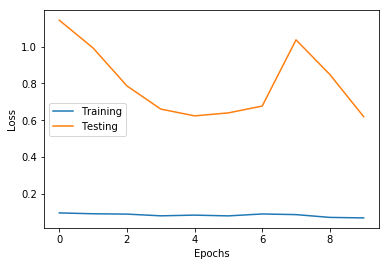

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

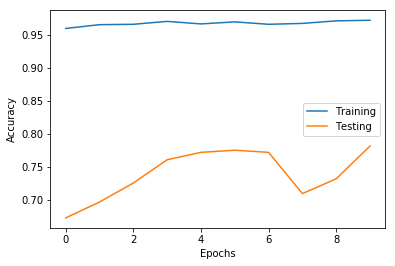

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'])
plt.show()

Evaluate model against the validation set

## Verifying the model

In [40]:
for path in sorted(os.listdir('./artifacts')):
    print(path)

01-val_accuracy-0.67-val_loss-1.14.hdf5
02-val_accuracy-0.70-val_loss-0.99.hdf5
03-val_accuracy-0.73-val_loss-0.79.hdf5
04-val_accuracy-0.76-val_loss-0.66.hdf5
05-val_accuracy-0.77-val_loss-0.62.hdf5
06-val_accuracy-0.78-val_loss-0.64.hdf5
09-val_accuracy-0.78-val_loss-0.53.hdf5
10-val_accuracy-0.7821-val_loss-0.62.hdf5


In [41]:
final_model = load_model('./artifacts/10-val_accuracy-0.7821-val_loss-0.62.hdf5')

In [56]:
train_result = final_model.evaluate_generator(train_generator, steps=len(train_generator), verbose=1)

print(f'Train Loss: {round(train_result[0], 2)}')
print(f'Train Accuracy: {round(train_result[1] * 100, 2)}%')

82/82 [==============================] - 181s 2s/step - loss: 0.2939 - accuracy: 0.8813
Train Loss: 0.29
Train Accuracy: 88.13%


In [42]:
test_result = final_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print(f'Test Loss: {round(test_result[0], 2)}')
print(f'Test Accuracy: {round(test_result[1] * 100, 2)}%')

20/20 [==============================] - 14s 720ms/step - loss: 0.6138 - accuracy: 0.7821
Test Loss: 0.61
Test Accuracy: 78.21%


In [43]:
val_result = final_model.evaluate_generator(val_generator, steps=len(test_generator), verbose=1)

print(f'Validation Loss: {round(val_result[0], 2)}')
print(f'Validation Accuracy: {round(val_result[1] * 100, 2)}%')

20/20 [==============================] - 8s 387ms/step - loss: 0.3553 - accuracy: 0.8125
Validation Loss: 0.36
Validation Accuracy: 81.25%


In [44]:
class_map = {v: k for k, v in test_generator.class_indices.items()}
print(class_map)
class_map = {v: k for k, v in train_generator.class_indices.items()}
print(class_map)
class_map = {v: k for k, v in val_generator.class_indices.items()}
print(class_map)

{0: 'NORMAL', 1: 'PNEUMONIA'}
{0: 'NORMAL', 1: 'PNEUMONIA'}
{0: 'NORMAL', 1: 'PNEUMONIA'}


In [54]:
def verify_predictions(images_set, images_class, count = 10):
    print(f'{images_set} - {images_class}')
    # plt.subplots(nrows=1, ncols=5, figsize=(25, 25))

    folder_path = f'{ASSETS}{images_set}/{images_class}'
    image_paths = glob.glob(f'{folder_path}/*.jpeg')
    selected_image_paths = image_paths # np.random.choice(image_paths, count)

    for idx, image_path in enumerate(selected_image_paths):
        image = cv2.imread(image_path)
        #plt.subplot(1, count, idx + 1)
        #plt.imshow(image)
        image = cv2.resize(image, (300, 300))
        prediction = final_model.predict(np.array([image]))
        predicted_class = class_map[int(prediction[0, 0])]
        print(predicted_class)
        #plt.title(f'Class: {images_class}\nPredicted: {predicted_class}')
    plt.show()

Prediction on the test and validation datasets

In [55]:
verify_predictions('train', 'NORMAL')
verify_predictions('train', 'PNEUMONIA')
verify_predictions('test', 'NORMAL')
verify_predictions('test', 'PNEUMONIA')
verify_predictions('val', 'NORMAL')
verify_predictions('val', 'PNEUMONIA')

train - NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUM

KeyboardInterrupt: 